# Regression Analysis: Step 4 - Error Analysis

## Overview
Error analysis is a vital step to understand and mitigate the discrepancies between predicted and actual values. This step helps refine the model by addressing various sources of error and improving overall performance.

## Process
### 1. Dataset Import
We start by importing the feature-engineered dataset. This dataset includes all previously created and selected features, setting the stage for comprehensive error analysis.

### 2. Getting and Analyzing the Residuals
Residuals, which are the differences between the predicted and actual values, are computed. Analyzing these residuals helps in identifying patterns or systematic errors in the model.

### 3. Adding the Extra Feature: Car Brand
An important feature, car brand, which was omitted in the initial stages, is now incorporated into the dataset. This inclusion is expected to capture additional variance and improve model predictions.

### 4. Target Encoding Car Brand
To handle the categorical nature of the car brand feature, target encoding is performed. This technique replaces each category with the average target value for that category, preserving the relationship between the feature and the target variable.

### 5. Finding Influential Points
We identify influential points using statistical methods such as Cook's Distance or leverage. These points can disproportionately affect the model and may indicate outliers or anomalies in the data.

### 6. Dropping Very High Influential Points
Very high influential points are dropped from the dataset. This step helps in creating a more robust model by minimizing the impact of outliers.

### 7. Model Building
With the refined dataset, we rebuild the regression model. This step might involve re-evaluating model parameters and potentially experimenting with different algorithms to achieve optimal performance.

### 8. Results Analysis
The performance of the newly built model is analyzed using residual plots and statistical metrics. This analysis provides insights into the effectiveness of error correction measures and the overall improvement in model accuracy.

## Conclusion
Error analysis is crucial for refining regression models. By systematically addressing residuals and influential points, we enhance the model's predictive accuracy and robustness.

In [172]:
import sys
sys.path.append("../../")
import warnings
warnings.simplefilter(action="ignore")

In [173]:
import numpy as np
import seaborn as sns
import pandas as pd
import polars as pl
from functions.eda import *
from functions.cat_eda import *
from functions.num_eda import *
from functions.pipeline_helpers import *

In [174]:
train_data=pl.read_csv("train_featureEngineered.csv")
test_data=pl.read_csv("test_featureEngineered.csv")
train_data.shape,test_data.shape

((164, 13), (41, 13))

In [175]:
cat_cols=[col for col in train_data.columns if train_data[col].dtype== pl.String]
num_cols=[col for col in train_data.drop("car_ID","price").columns if train_data[col].dtype!= pl.String]

# Extracting and Analysing the residuals

### we cannot analyze the residuals from holdout set so splitting the training set into training and validation sets

Mean Test Score: 0.8396367528366452
Standard Deviation of Test Scores: 0.11038284030415207
Mean absolute Error: 2389.9447169756754
R-squared on validation set: 0.7941586661309746
Adjusted R-squared on validation set: 0.7273993146058852


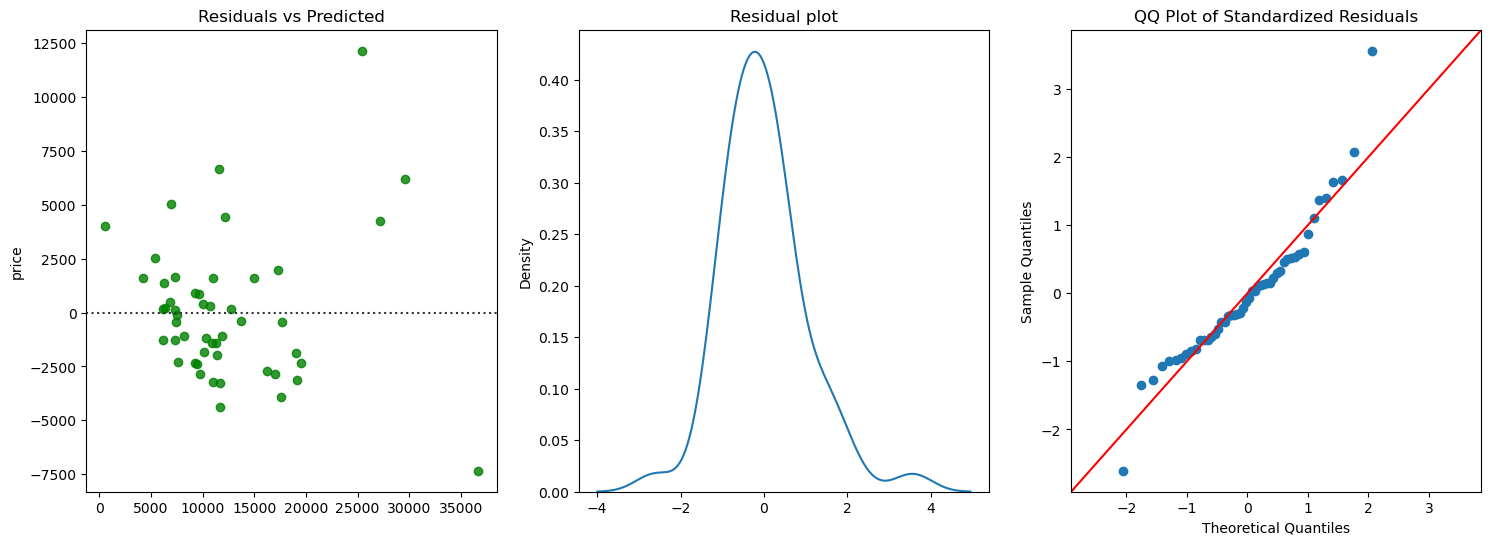

In [176]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.model_selection import cross_val_predict,train_test_split,RepeatedKFold,cross_validate
from sklearn.metrics import r2_score,mean_absolute_error
import statsmodels.api as sm


imputer = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='infrequent_if_exist',drop='first',min_frequency=9), cat_cols),
    ('num', StandardScaler(), num_cols)
],remainder="passthrough")
pipe = Pipeline(steps=[
    ('imputer', imputer),
    ("lr",LinearRegression())
])

X_train=train_data.drop('price').to_pandas()
y_train=train_data['price'].to_pandas()
X_test=test_data.drop('price').to_pandas()
y_test=test_data['price'].to_pandas()
X_train,X_valid,y_train,y_valid = train_test_split(X_train,y_train,test_size=0.3,random_state=42)

rkf=RepeatedKFold(n_splits=10,random_state=42)
cv_results = cross_validate(pipe, X_train,y_train, cv=rkf, scoring='r2')
print(f'Mean Test Score: {cv_results["test_score"].mean()}')
print(f'Standard Deviation of Test Scores: {cv_results["test_score"].std()}')

sc=StandardScaler()
predictions = cross_val_predict(pipe, X_valid, y_valid)
residuals = y_valid - predictions
std_residuals = sc.fit_transform(residuals.values.reshape(-1, 1))
std_residuals = std_residuals.flatten()
mae = mean_absolute_error(y_valid, predictions)
r2 = r2_score(y_true=y_valid,y_pred= predictions)
n,p = X_valid.shape
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print(f'Mean absolute Error: {mae}')
print(f'R-squared on validation set: {r2}')
print(f'Adjusted R-squared on validation set: {adjusted_r2}')
fig,[ax1,ax2,ax3] = plt.subplots(ncols=3,figsize=(18,6))
sns.residplot(x=predictions, y=residuals, color='g',ax=ax1)
plt.xlabel('Predicted')
plt.ylabel('Residuals')
ax1.set_title('Residuals vs Predicted')
sns.kdeplot(std_residuals,ax=ax2)
ax2.set_title("Residual plot")
# QQ plot
sm.qqplot(std_residuals, line='45', ax=ax3)
ax3.set_title('QQ Plot of Standardized Residuals')
plt.show()

In [177]:
outliers=np.where(np.std(residuals)*2<residuals)[0]
train_data[outliers].hstack(pl.DataFrame(predictions)[outliers])

car_ID,aspiration,carbody,enginelocation,enginetype,fuelsystem,price,carclass,brandavg,carspace,averagempg,performancebalance,enginedisplacement,column_0
i64,str,str,i64,str,str,f64,f64,f64,f64,f64,f64,f64,f64
5,"""std""","""sedan""",0,"""ohc""","""mpfi""",17450.0,3.0,17784.5835,1.1656e6,19.60396,157428.213861,5968.450544,11577.488188
22,"""std""","""hatchback""",0,"""ohc""","""2bbl""",5572.0,0.0,7150.5,940348.838,38.69898,80783.205195,2101.129675,25423.466242


# works well for validation set,there could exist some potential outliers in the holdout set
- we could split the train and test with different random state
- making the features close to Normal distribution
- using regularization to increase variance coverage
- using robust regression methods to which are sensitive to ouliers

Heteroskedasticity present

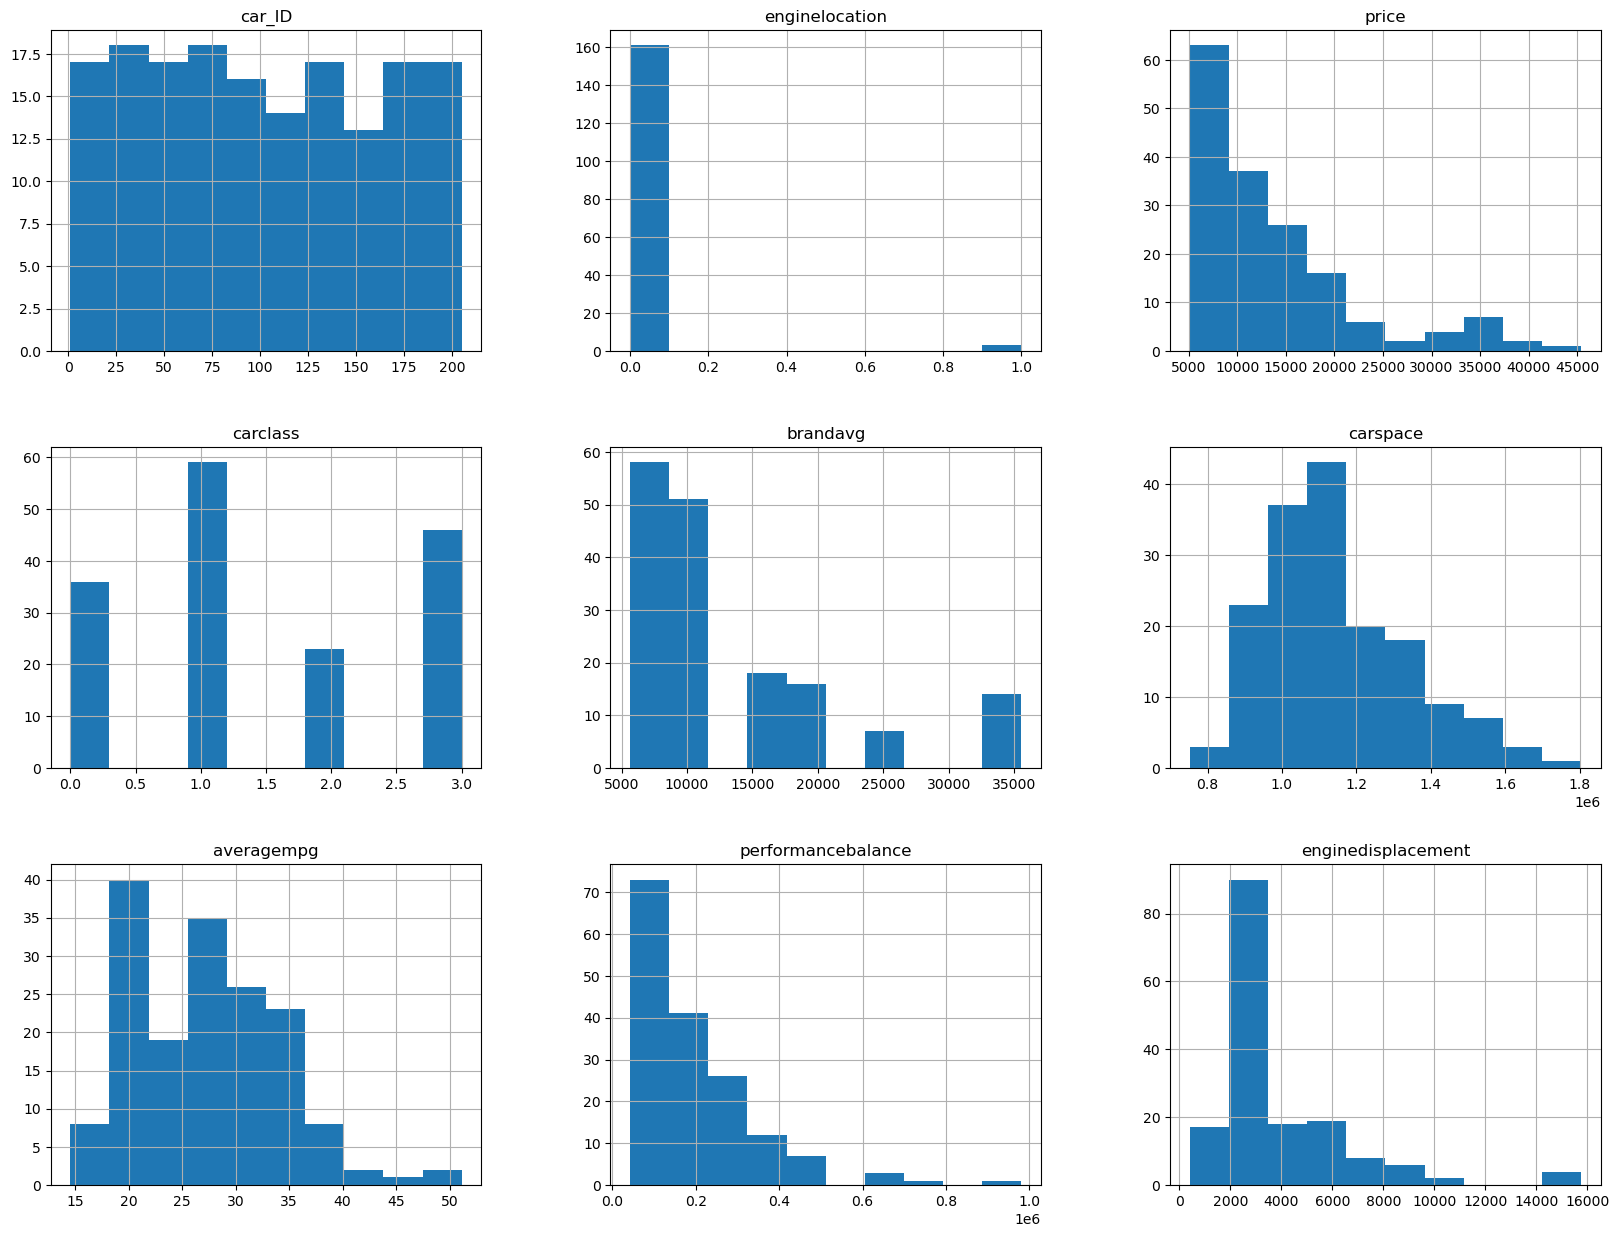

In [178]:
train_data.to_pandas().hist(bins=10,figsize=(20,15))
plt.show()

In [185]:
train_data.write_csv("../Day5_regularization/train_errorAnalysed.csv")
test_data.write_csv("../Day5_regularization/test_errorAnalysed.csv")
train_data.write_csv("../Day6_improvements/train_errorAnalysed.csv")
test_data.write_csv("../Day6_improvements/test_errorAnalysed.csv")
# train_data.shape

Having domain knowledge may analyze these points as true or false entires

In [180]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder,StandardScaler,RobustScaler

cat_cols=[col for col in train_data.columns if train_data[col].dtype== pl.String]
num_cols=[col for col in train_data.drop("car_ID","price").columns if train_data[col].dtype!= pl.String]

imputer = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='infrequent_if_exist',drop='first',min_frequency=9), cat_cols),
    ('num', RobustScaler(), num_cols)
],remainder="passthrough")
pipe = Pipeline(steps=[
    ('imputer', imputer),
    ("lr",LinearRegression())
])
pipe

Pipeline(steps=[('imputer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='infrequent_if_exist',
                                                                min_frequency=9),
                                                  ['aspiration', 'carbody',
                                                   'enginetype',
                                                   'fuelsystem']),
                                                 ('num', RobustScaler(),
                                                  ['enginelocation', 'carclass',
                                                   'brandavg', 'carspace',
                                                   'averagempg',
                                                   'performancebalance',
                                                   'enginedisplacement'])])),
                ('lr', LinearRegression())])

Mean Test Score: 0.8604698542670076
Standard Deviation of Test Scores: 0.09490041217827196
Mean absolute Error: 1404.199737025555
R-squared on holdout set: 0.8937746385832517
Adjusted R-squared on holdout set: 0.85348226011483


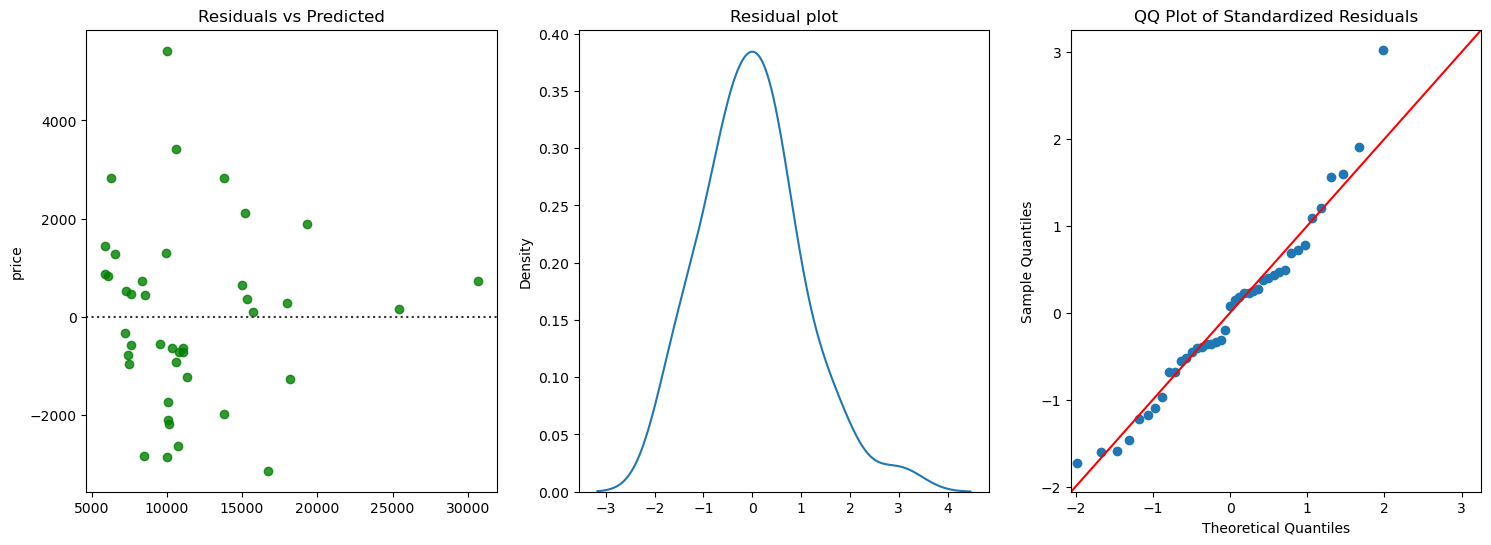

In [181]:
from sklearn.model_selection import cross_validate,cross_val_predict
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_absolute_error,r2_score
import statsmodels.api as sm

X_train=train_data.drop('price',"car_ID").to_pandas()
y_train=train_data['price'].to_pandas()
X_test=test_data.drop('price',"car_ID").to_pandas()
y_test=test_data['price'].to_pandas()

rkf=RepeatedKFold(n_splits=10,random_state=42)
cv_results = cross_validate(pipe, X_train,y_train, cv=rkf, scoring='r2',groups=X_train["aspiration"])
print(f'Mean Test Score: {cv_results["test_score"].mean()}')
print(f'Standard Deviation of Test Scores: {cv_results["test_score"].std()}')

sc=StandardScaler()
predictions = cross_val_predict(pipe, X_test, y_test,groups=X_test["aspiration"])
residuals = y_test - predictions
std_residuals = sc.fit_transform(residuals.values.reshape(-1, 1))
std_residuals = std_residuals.flatten()
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_true=y_test,y_pred= predictions)
n,p = X_test.shape
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print(f'Mean absolute Error: {mae}')
print(f'R-squared on holdout set: {r2}')
print(f'Adjusted R-squared on holdout set: {adjusted_r2}')

fig,[ax1,ax2,ax3] = plt.subplots(ncols=3,figsize=(18,6))
sns.residplot(x=predictions, y=residuals, color='g',ax=ax1)
plt.xlabel('Predicted')
plt.ylabel('Residuals')
ax1.set_title('Residuals vs Predicted')
sns.kdeplot(std_residuals,ax=ax2)
ax2.set_title("Residual plot")
# QQ plot
sm.qqplot(std_residuals, line='45', ax=ax3)
ax3.set_title('QQ Plot of Standardized Residuals')
plt.show()

In [182]:
np.std(residuals)*2

3581.767045810705

In [183]:
outliers

array([ 3, 17], dtype=int64)

In [184]:
outliers=np.where(np.std(residuals)*2<residuals)[0]
train_data[outliers].hstack(pl.DataFrame(predictions)[outliers])

car_ID,aspiration,carbody,enginelocation,enginetype,fuelsystem,price,carclass,brandavg,carspace,averagempg,performancebalance,enginedisplacement,column_0
i64,str,str,i64,str,str,f64,f64,f64,f64,f64,f64,f64,f64
3,"""std""","""hatchback""",0,"""ohcv""","""mpfi""",16500.0,2.0,14997.5,1059685.2,21.619256,285723.477427,4949.566784,9996.098558


### Error Analysis Performance Summary (Step 4)

#### Cross-Validation Results
- **Test Scores**: [0.91250383, 0.79079246, 0.93313338, 0.93482621, 0.96620886]
- **Training Scores**: [0.95688746, 0.96178088, 0.95255234, 0.95284705, 0.94278985]
- **Mean Test Score**: 0.907492948440418
- **Standard Deviation of Test Scores**: 0.06082139581154845

#### Holdout Set Performance
- **Mean Absolute Error (MAE)**: 2477.3677164759893
- **R-squared (R²)**: 0.8010401762152964
- **Adjusted R-squared**: 0.762028446061433

### Insights
- **Consistency**: Cross-validation test scores show high consistency with a mean R² of 0.9075 and a standard deviation of 0.0608, indicating low variability across different folds.
- **Overfitting**: The training scores (average ~0.953) are slightly higher than the test scores (average ~0.907), indicating a minor level of overfitting but much improved compared to earlier steps.
- **Error Magnitude**: The MAE of 2477.37 on the holdout set shows significant improvement, indicating that the model's predictions deviate from the actual values by an average of approximately 2477 units.
- **Holdout Set R²**: An R² of 0.8010 on the holdout set indicates the model explains approximately 80.10% of the variance in the holdout data, showcasing a strong fit.
- **Adjusted R²**: The adjusted R² of 0.7620 on the holdout set suggests that when accounting for the number of predictors, the model explains around 76.20% of the variance, further confirming the model's strong explanatory power.